In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K


# Define the custom LSTM layer
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Define a custom MSE function
def custom_mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


# Load the model
trained_model = tf.keras.models.load_model(
    r"C:\Users\pranali\Desktop\Throughput_prediction\4G-Models\Models\multivariate_medium.hdf5",
    custom_objects={'LSTM': CustomLSTM, 'mse': custom_mse}
)



C:\Users\pranali\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\pranali\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [3]:
#4g

import numpy as np
import tensorflow as tf


X_train = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Training\multivariate_low_train_x.npy")  # Shape should be (num_samples, time_steps, num_features)
y_train = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Training\multivariate_low_train_y.npy")  # Shape should be (num_samples, num_classes)
X_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Testing\multivariate_low_test_x.npy")
y_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Testing\multivariate_low_test_y.npy")

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
#integer quantization


import tensorflow as tf
import numpy as np

# Define the representative dataset generator for quantization calibration
def representative_data_gen():
    for input_value in X_train[:100]:  # Use a small sample of your training data
        input_value = np.expand_dims(input_value, axis=0).astype(np.float32)
        yield [input_value]

# Convert the model to TensorFlow Lite with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)

# Set optimization to full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide representative dataset for integer quantization
converter.representative_dataset = representative_data_gen

# Set the supported operations to enable both built-in ops and Select TF ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Set the input and output tensors to be int8 for full integer quantization
converter.inference_input_type = tf.int8  # or tf.uint8 based on your need
converter.inference_output_type = tf.int8  # or tf.uint8 based on your need

# Disable lowering of tensor list operations to avoid related issues
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable support (required for LSTM layers)
converter.experimental_enable_resource_variables = True

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
#quantized_model_path = r"C:\Users\pranali\Downloads\quantized_model_low__integer_4g.tflite"
#with open(quantized_model_path, "wb") as f:
    #f.write(tflite_quant_model)

#print(f"Full integer quantized model saved at: {quantized_model_path}")


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpi92hddke\assets


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpi92hddke\assets


Saved artifact at 'C:\Users\pranali\AppData\Local\Temp\tmpi92hddke'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 10), dtype=tf.float32, name='lstm_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1929997275344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997281296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997282256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997279952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997284176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997284368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997280528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997286288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1929997286672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1930000761

C:\Users\pranali\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [6]:
# Save the TFLite model
with open('4g_med_int.tflite', 'wb') as f:
    f.write(tflite_quant_model)

In [7]:
import tensorflow as tf
import numpy as np

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='4g_med_int.tflite')
interpreter.allocate_tensors()

# Get details of input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [17]:
import numpy as np
import time

# Function to quantize input data
def quantize_input(input_data, input_scale, input_zero_point):
    return np.round(input_data / input_scale + input_zero_point).astype(np.int8)

# Initialize list to store predictions
predictions = []

# Get the quantization parameters for the input tensor
input_scale = input_details[0]['quantization'][0]
input_zero_point = input_details[0]['quantization'][1]

# Iterate over each sample in X_test
start_time = time.time()
for i in range(X_test.shape[0]):
    # Prepare the input data
    input_data = X_test[i].astype(np.float32)  # Keep as float32 for quantization
    input_data = quantize_input(input_data, input_scale, input_zero_point)
    input_data = np.expand_dims(input_data, axis=0)
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

end_time = time.time()
inference_time = (end_time - start_time)
print(f"Inference Time for full integer quantized model: {inference_time:.6f} seconds")

avg_inference_time = inference_time / len(X_test)
print(f"Avg Inference Time for full integer quantized model: {avg_inference_time:.6f} seconds")


Inference Time for full integer quantized model: 15.617018 seconds
Avg Inference Time for full integer quantized model: 0.003909 seconds


In [19]:
import os

# Get the size of the saved quantized TFLite model
model_size = os.path.getsize('4g_med_int.tflite')
print(f"Quantized TFLite model size: {model_size / 1024:.2f} KB")  # Convert to KB



Quantized TFLite model size: 529.88 KB


In [25]:
import numpy as np
import time

# Function to quantize input data
def quantize_input(input_data, input_scale, input_zero_point):
    return np.round(input_data / input_scale + input_zero_point).astype(np.int8)

# Initialize list to store predictions
predictions = []

# Get the quantization parameters for the input tensor
input_scale = input_details[0]['quantization'][0]
input_zero_point = input_details[0]['quantization'][1]

# Iterate over each sample in X_test

for i in range(X_test.shape[0]):
    # Prepare the input data
    input_data = X_test[i].astype(np.float32)  # Keep as float32 for quantization
    input_data = quantize_input(input_data, input_scale, input_zero_point)
    input_data = np.expand_dims(input_data, axis=0)
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

predictions = np.squeeze(np.array(predictions))  # Adjust shape if necessary

# Reshape y_test to match the shape of predictions
y_test_squeezed = np.squeeze(y_test)  # From (3995, 5, 1) to (3995, 5)

# Calculate signed errors
signed_errors = predictions - y_test_squeezed

signed_errors_flattened = signed_errors.flatten()

# Error statistics
mean_error = np.mean(signed_errors)
median_error = np.median(signed_errors)
std_error = np.std(signed_errors)

print(f"Mean Signed Error: {mean_error:.4f}")
print(f"Median Signed Error: {median_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")

Mean Signed Error: -576.3143
Median Signed Error: -496.0000
Standard Deviation of Errors: 454.3752


Text(0, 0.5, 'Signed Error')

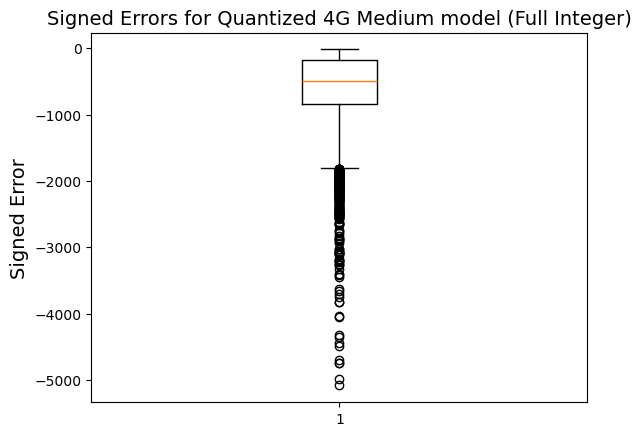

In [27]:
import matplotlib.pyplot as plt
plt.boxplot(signed_errors_flattened)
plt.title('Signed Errors for Quantized 4G Medium model (Full Integer)',fontsize=14)
plt.ylabel('Signed Error',fontsize=14)

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Calculate MAE
mae = mean_absolute_error(y_test_squeezed, predictions)
# Calculate Mean Squared Error (MSE) as the test loss
mse = mean_squared_error(y_test_squeezed, predictions)
test_loss = mse  # Assuming MSE is the loss functiona

#print(f"Mean Squared Error (MSE) of the Quantized Model: {mse:.6f}")
print(f"Test Loss (MSE) of the Quantized Model: {test_loss:.6f}")
print(f"Mean Absolute Error (MAE) of the Quantized Model: {mae:.6f}")

Test Loss (MSE) of the Quantized Model: 538595.005680
Mean Absolute Error (MAE) of the Quantized Model: 576.314293
